In [3]:
import sys
sys.path.append("/b2p")

In [4]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import os
from glob import glob 
import rasterio
from rasterio import features
from rasterio.windows import Window
import geopandas as gpd
import numpy as np
import copy
from tqdm.notebook import tqdm 
import warnings
# filter out RuntimeWarnings, due to geopandas/fiona read file spam
# https://stackoverflow.com/questions/64995369/geopandas-warning-on-read-file
warnings.filterwarnings("ignore",category=RuntimeWarning)

In [14]:
data_dir = '/b2p/data/tmp_s2/Rwanda/all/35MPR'
bands = ['B02', 'B03','B04']

In [35]:
def getImgFromFile(img_path, g_ncols, dtype, row_bound=None):
    img = rasterio.open(img_path, driver='JP2OpenJPEG')
    transform = img.transform
    crs = img.crs
    ncols, nrows = img.meta['width'], img.meta['height']
    assert g_ncols == ncols, f'Imgs have different size ncols: {ncols} neq {g_ncols}'
    if row_bound is None:
        pixels = img.read(1).astype(np.float32)
    else:
        pixels = img.read(
            1,
            window=Window.from_slices(
                        slice(row_bound[0], row_bound[1]),
                        slice(0, ncols)
                    )
        ).astype(dtype)
    return pixels, crs, transform
def getCloudMaskFromFile(cloud_path, crs, transform, shape, row_bound=None):
    try: 
        cloud_file = gpd.read_file(cloud_path)
        cloud_file.crs = (str(crs))
        # convert the cloud mask data to a raster that has the same shape and transformation as the
        # img raster data
        cloud_img = features.rasterize(
            (
                (g['geometry'], 1) for v, g in cloud_file.iterrows()
            ),
            out_shape=shape,
            transform=transform, 
            all_touched=True
        )
        if row_bound is None:
            return np.where(cloud_img == 0, 1, 0)
        return np.where(cloud_img[row_bound[0]:row_bound[1],:] == 0, 1, 0)
    except: 
        trues = np.ones(shape)
        if row_bound is None:
            return trues
        return trues[row_bound[0]:row_bound[1],:]

In [33]:
np.ones((10,10))

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [27]:
def nanClouds(pixels, cloud_channels, max_pixel_val:float=4000):
    cp = pixels * cloud_channels
    mask = np.where(np.logical_or(cp == 0, cp > max_pixel_val ))
    cp[mask] = np.nan
    return cp

In [19]:
band = 'B04'
num_slices = 3
band_files = glob(os.path.join(data_dir, f'**/*{band}*.jp2'), recursive=True)

In [20]:
img_path = band_files[1]
meta = rasterio.open(img_path, driver='JP2OpenJPEG').meta
g_nrows, g_ncols = meta['width'], meta['height']
slice_width = g_nrows / num_slices
slice_end_pts = [int(i) for i in np.arange(0, g_nrows + slice_width, slice_width)]
slice_bounds = [ (slice_end_pts[i], slice_end_pts[i+1]-1)  for i in range(num_slices-1)]
slice_bounds.append((slice_end_pts[-2], slice_end_pts[-1]))
pixels, crs, transform = getImgFromFile(img_path, g_ncols)
date_dir = os.path.dirname(img_path)
cloud_files = glob(os.path.join(date_dir, "*.gml"))
assert len(cloud_files) == 1, f'Cloud path does not exist for {date_dir}'
cloud_channels = getCloudMaskFromFile(cloud_files[0], crs, transform, (g_nrows, g_ncols))
c_pixels = nanClouds(pixels, cloud_channels)

<IPython.core.display.Javascript object>


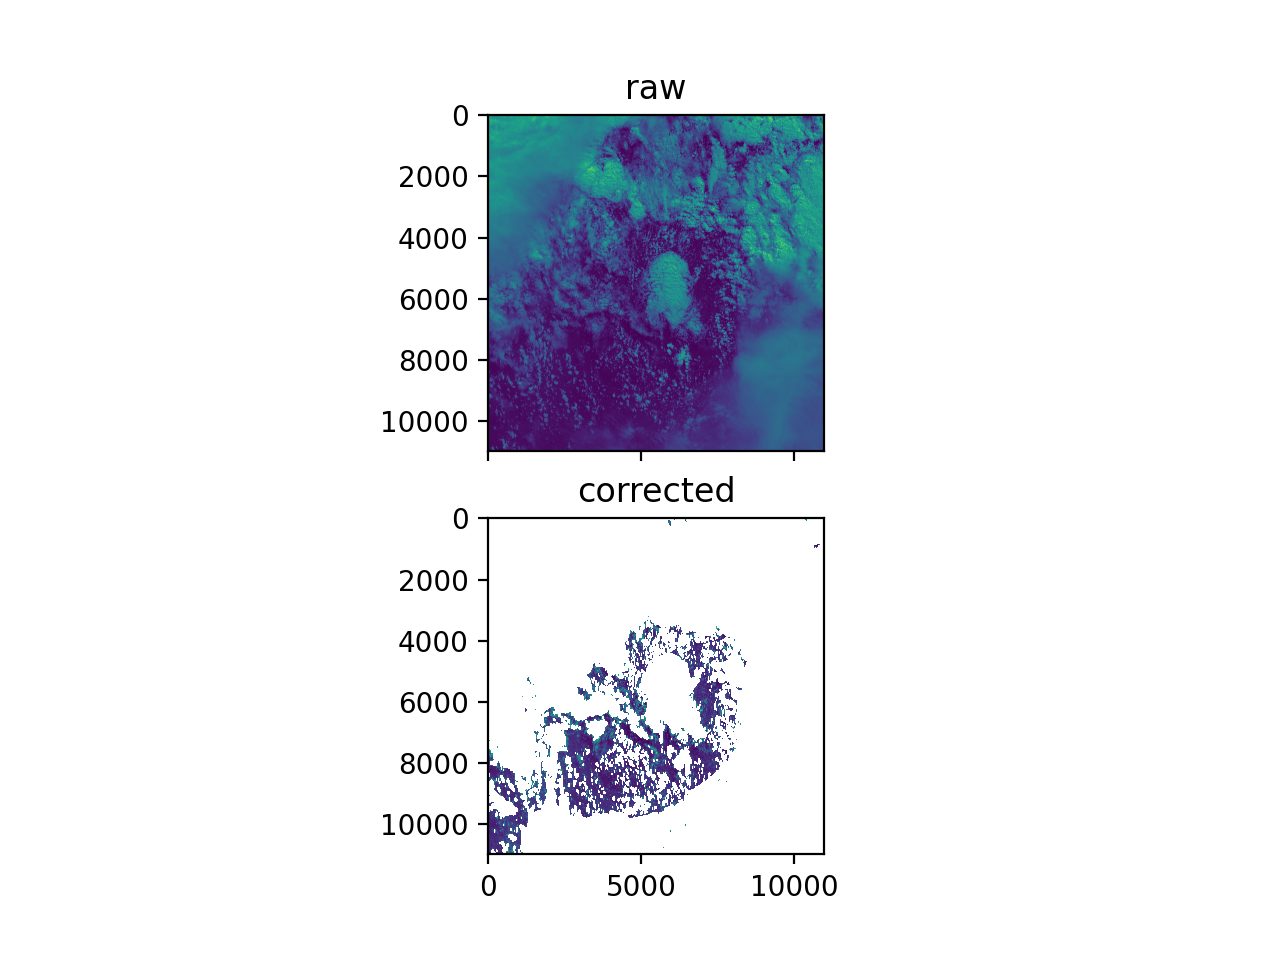

In [21]:
fig, axs = plt.subplots(2,sharex=True, sharey=True)
axs[0].imshow(pixels)
axs[0].title.set_text('raw')
axs[1].imshow(c_pixels)
axs[1].title.set_text('corrected')
plt.show()

In [ ]:
img = rasterio.open(img_path, driver='JP2OpenJPEG')
pixels = img.read(1).astype(np.float32)
# plt.imshow(pixels)
hella, _,_ = getImgFromFile(img_path, g_ncols)
hella

In [37]:
tmp_dir = './data/test_composite'
os.makedirs(tmp_dir, exist_ok=True)
dtype = np.float32
crs = None
num_slices = 3
# Loop through each band, getting a median estimate for each
for band in tqdm(bands, desc=f'Processing:', leave=True, position=0):
    band_files = glob(os.path.join(data_dir, f'**/*{band}*.jp2'))
    assert len(band_files) > 1
    meta = rasterio.open(band_files[0], driver='JP2OpenJPEG').meta
    g_nrows, g_ncols = meta['width'], meta['height']
    # handel slicing if necessary, slicing along rows only
    if num_slices > 1:
        slice_width = g_nrows / num_slices
        slice_end_pts = [int(i) for i in np.arange(0, g_nrows + slice_width, slice_width)]
        slice_bounds = [ (slice_end_pts[i], slice_end_pts[i+1]-1)  for i in range(num_slices-1)]
        slice_bounds.append((slice_end_pts[-2], slice_end_pts[-1]))
    else: 
        slice_bounds = [None]
    # Loop through slices
    for k, row_bound in tqdm(enumerate(slice_bounds), desc=f'Slicing band {band}', leave=True, position=1, total=num_slices): 
        cloud_correct_imgs = []
        for img_path in tqdm(band_files, desc=f'slice={k}',leave=False,position=2):
            # Get data from files
            pixels, crs, transform = getImgFromFile(img_path, g_ncols, dtype, row_bound)
            date_dir = os.path.dirname(img_path)
            cloud_files = glob(os.path.join(date_dir, "*.gml"))
            assert len(cloud_files) == 1, f'Cloud path does not exist for {date_dir}'
            
            cloud_channels = getCloudMaskFromFile(cloud_files[0], crs, transform, (g_nrows, g_ncols), row_bound)
            # add to list to do median filte later
            cloud_correct_imgs.append(nanClouds(pixels, cloud_channels) ) 
            del pixels

        corrected_stack = np.vstack([img.ravel() for img in cloud_correct_imgs])
        median_corrected = np.nanmedian(corrected_stack, axis=0, overwrite_input=True)
        median_corrected = median_corrected.reshape(cloud_correct_imgs[0].shape)
        if num_slices > 1:
            outpath = os.path.join(tmp_dir, f'{band}_slice{k}.tiff')
        else:
            outpath = os.path.join(tmp_dir, f'{band}.tiff')
        with rasterio.open(outpath, 'w', driver='Gtiff', width=g_ncols, height=g_nrows, count=1, crs=crs,
                                   transform=transform, dtype=dtype) as wf:
            wf.write(median_corrected.astype(dtype), 1)
        # release mem
        median_corrected = []
        del median_corrected
        corrected_stack = []
        del corrected_stack
   
        

Processing::   0%|          | 0/3 [00:00<?, ?it/s]

Slicing band B02: 0it [00:00, ?it/s]

slice=0:   0%|          | 0/24 [00:00<?, ?it/s]

ValueError: the array's dtype 'float64' does not match the file's dtype 'float32'

In [42]:
with rasterio.open(outpath, 'w', driver='Gtiff', width=g_ncols, height=g_nrows, count=1, crs=crs,
                                   transform=transform, dtype=dtype) as wf:
        wf.write(median_corrected.astype(dtype), 1)

<IPython.core.display.Javascript object>


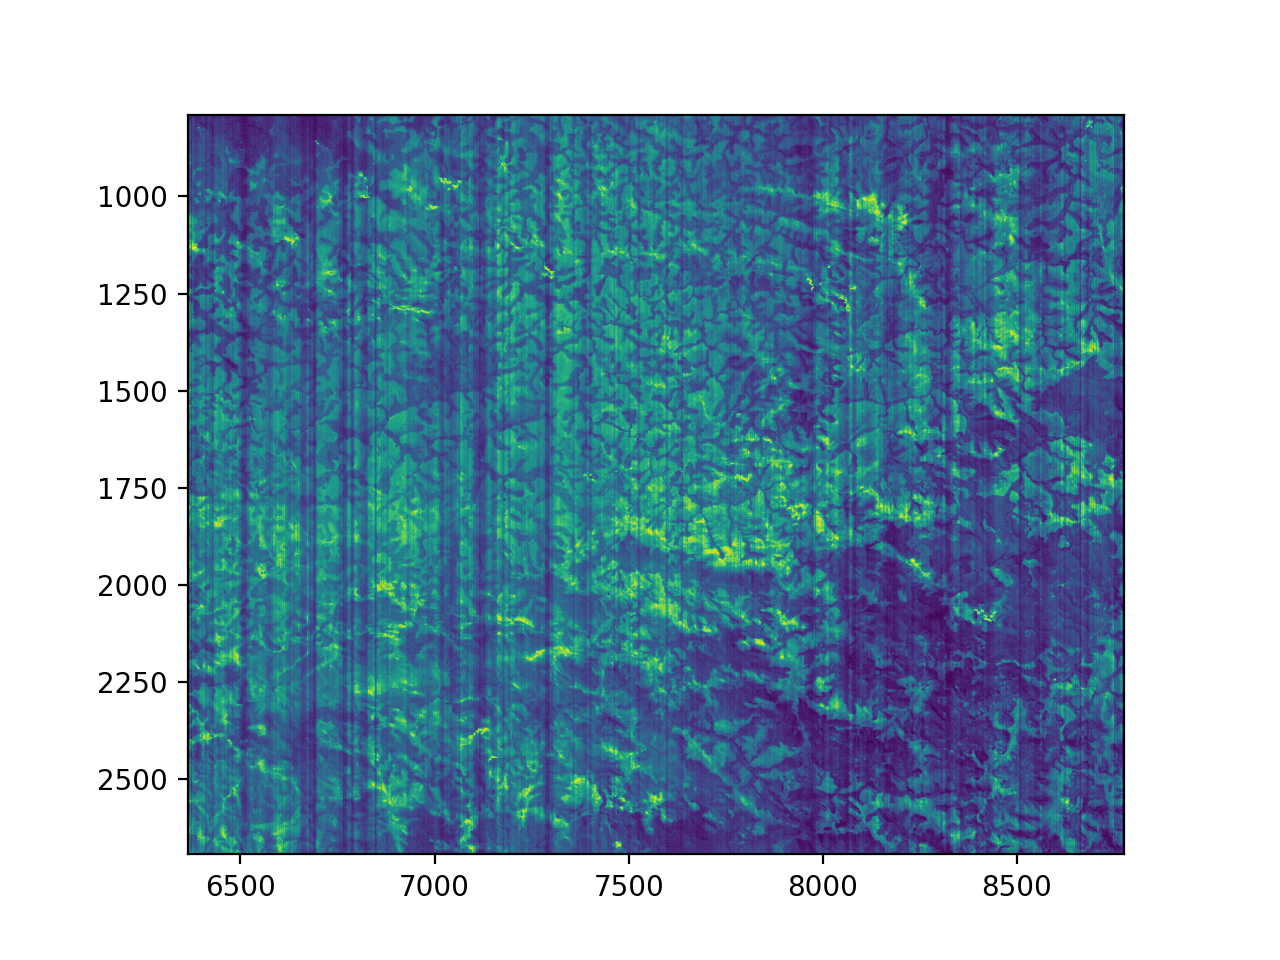

In [57]:

from sklearn import preprocessing as p
  
# create an array
data = np.array([[10, 20], [30, 40],
                 [5, 15], [0, 10]])
  
min_max_scaler = p.MinMaxScaler()
normalizedData = min_max_scaler.fit_transform(median_corrected)*256

normalizedData = np.round(normalizedData).astype(np.int16)
plt.subplots()
plt.imshow(normalizedData)
plt.show()

In [ ]:
 ## combine slices into one master file 
    if num_slices > 1:
        outpath = os.path.join(tmp_dir, f'{band}_slice{k}.tiff')
        with rasterio.open(outpath, 'w', driver='GTiff', width=g_ncols, height=g_nrows, count=1, crs=crs,
                               transform=transform, dtype=dtype) as wf:
            for k, row_bound in enumerate(slice_bounds):
                slice_file_path = os.path.join(tmp_dir, f'{band}_slice{k}.tiff')
                with rasterio.open(slice_file_path) as rf: 
                    wf.write(
                        rf.read(1), 
                        window=Window.from_slices(
                            slice(row_bound[0], row_bound[1]), 
                            slice(0, g_ncols)
                        ),
                        indexes=1
                    )
                os.remove(slice_file_path)
                

In [ ]:
from src.api.sentinel2 import SinergiseSentinelAPI

# Download New Data

In [7]:
from src.api.sentinel2 import SinergiseSentinelAPI
buffer = 100
api = SinergiseSentinelAPI()

In [8]:
# Rwanda (first month of dry szn)
bbox = [28.7869, -3.6889, 30.9732, -0.1978]
outdir = './data/tmp_s2/Rwanda/all'
start_date = '2019-06-03'
end_date = '2019-07-31'

In [9]:
os.makedirs(outdir, exist_ok=True)
api.download(bbox, buffer, outdir, start_date, end_date)

Finding overlapping tiles... 
Found 1552 files for download. Total size of files is 76.95GB and estimated cost will be $6.93. Proceed (y/n)?y


100%|██████████| 1552/1552 [08:09<00:00,  3.17it/s]


In [ ]:
# Uganda
d_to_bbox = { Kabarole: [30.0675, 0.1847, 30.6141, 1.0581],
    Kasese: [29.4585, -0.7429, 30.5516, 1.0038],
    Ibanda: [30.1691, -0.4964, 30.7157, 0.3770]
}
for district, bbox in d_to_bbox.items():
    outdir = os.path.join('./data/tmp_s2/Rwanda', district)
    # get first dry szn
    start_date = '2019-06-15'
    end_date = '2019-08-15'
    os.makedirs(outdir, exist_ok=True)
    api.download(bbox, buffer, outdir, start_date, end_date)
    start_date = '2019-01-01'
    end_date = '2019-02-28'